In [5]:
import torch, torch.nn as nn, torch.optim as optim, time

# ---- Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} | GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

# ---- Dummy data ----
# 100,000 samples, 100 features each
X = torch.randn(100_000, 100, device=device)
y = torch.randn(100_000, 1, device=device)

# ---- Simple model ----
model = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ---- Training loop ----
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

start = time.time()
for epoch in range(5):
    optimizer.zero_grad(set_to_none=True)
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/5 | Loss: {loss.item():.4f}")
torch.cuda.synchronize()
print("Total training time:", round(time.time() - start, 3), "s")


Using device: cuda | GPU: NVIDIA A40
Epoch 1/5 | Loss: 1.0937
Epoch 2/5 | Loss: 1.0527
Epoch 3/5 | Loss: 1.0271
Epoch 4/5 | Loss: 1.0148
Epoch 5/5 | Loss: 1.0119
Total training time: 0.016 s


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

TARGET = "Critical Cooling Rate"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
FEATURES = {
    "PI": ['size_diff', 'size_ratio', 'size_range', 'DeltaH', 'CrystalMismatch', 'Tmean'],
    "EP": ['Composition', 'CompositionA',
        'Atomic Number', 'Mendeleev Number', 'Atomic Weight',
        'Melting Temperature (K)', 'Column', 'Row', 'Covalent Radius',
        'Electronegativity', '# s Valence Electrons', '# p Valence Electrons',
        '# d Valence Electrons', '# f Valence Electrons',
        'Total # Valence Electrons', '# Unfilled s States',
        '# Unfilled p States', '# Unfilled d States', '# Unfilled f States',
        'Total # Unfilled States', 'Specific Volume of 0K Ground State',
        'Band Gap Energy of 0K Ground State',
        'Magnetic Moment of 0K Gound State', 'Space Goup # of 0K Ground State',
        'Radius by Miracle (Atomic size)', 'Boiling Temperature', 'Density',
        '1st Ioniztion Energy', 'Mass Heat Capacity', 'Molar Heat Capacity',
        'Heat of Fusion', 'Phi', 'n_ws 3rd', 'Cohesive E', 'Atomic NumberB',
        'Mendeleev NumberB', 'Atomic WeightB', 'Melting Temperature (K)B',
        'ColumnB', 'RowB', 'Covalent RadiusB', 'ElectronegativityB',
        '# s Valence ElectronsB', '# p Valence ElectronsB',
        '# d Valence ElectronsB', '# f Valence ElectronsB',
        'Total # Valence ElectronsB', '# Unfilled s StatesB',
        '# Unfilled p StatesB', '# Unfilled d StatesB', '# Unfilled f StatesB',
        'Total # Unfilled StatesB', 'Specific Volume of 0K Ground StateB',
        'Band Gap Energy of 0K Ground StateB',
        'Magnetic Moment of 0K Gound StateB',
        'Space Goup # of 0K Ground StateB', 'Radius by Miracle (Atomic size)B',
        'Boiling TemperatureB', 'DensityB', '1st Ioniztion EnergyB',
        'Mass Heat CapacityB', 'Molar Heat CapacityB', 'Heat of FusionB',
        'PhiB', 'n_ws 3rdB', 'Cohesive EB'],
    "Comp": ['W', 'Ni', 'Fe', 'Mg', 'Pd', 'Al', 'Ta', 'Sn', 'Cu', 'Hf', 'Nb', 'Ag','Pt', 'Ti', 'Mo', 
            'V', 'Zr', 'Mn', 'Au', 'Co', 'Si', 'Y', 'Cr', 'Ge'],
    "Random": ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
}

In [8]:
def prepare_dataset(df: pd.DataFrame, dataset_name: str, device=None):
    selected = FEATURES[dataset_name]
    X = torch.tensor(df[selected].values, dtype=torch.float32)
    y = torch.tensor(df[TARGET].values, dtype=torch.float32)
    if device is not None:
        X = X.to(device)
        y = y.to(device)
    
    return X, y

In [9]:
def has_bad(t):
    return torch.isnan(t).any() or torch.isinf(t).any()

In [10]:
df_pi   = pd.read_csv("rc_PI_binary.csv")
df_ep   = pd.read_csv("rc_EP_binary.csv")
df_comp = pd.read_csv("rc_Comp_binary.csv")
df_rand = pd.read_csv("rc_Random_binary.csv")

In [11]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
class BetterNN(nn.Module):
    def __init__(self, input_dim, widths=(128, 64, 32), p=0.15):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.LeakyReLU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [13]:
def plot_pred_vs_actual(per_system_results, n=6, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    choices = rng.choice(len(per_system_results), size=min(n, len(per_system_results)), replace=False)
    figs = []
    for idx in choices:
        system, y_true, y_pred = per_system_results[idx]
        plt.figure()
        plt.scatter(y_true, y_pred, s=10)
        m = max(np.max(y_true), np.max(y_pred))
        plt.plot([0, m], [0, m], lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(system)
        plt.show()

def plot_error_hist(per_system_results):
    errors = np.concatenate([pred - true for _, true, pred in per_system_results])
    plt.figure()
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction - Actual"); plt.ylabel("Count"); plt.title("Error Histogram")
    plt.show()

In [21]:
import torch, numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

def run_loop_gpu_cached(df: pd.DataFrame, feature: str, epochs: int = 50, batch_size: int = 1024, lr: float = 1e-3, device=None):
    assert device is not None, "Pass a torch.device, e.g., torch.device('cuda')"

    # --- Fast kernels/matmul ---
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")  # PyTorch 2.x

    # --- 1) Build the FULL dataset ONCE, on GPU ---
    # prepare_dataset should return torch.float tensors; adapt if needed.
    X_all, y_all = prepare_dataset(df, feature, device=device)  # shapes [N, D], [N]
    y_all = y_all.view(-1)  # ensure 1D

    # Encode "Alloy System" as integer IDs, then move IDs to GPU (tiny)
    sys_cats = pd.Categorical(df["Alloy System"])
    systems = sys_cats.categories.tolist()              # list of unique names (kept for printing)
    sys_ids_cpu = torch.from_numpy(sys_cats.codes)      # [N] int32 on CPU
    sys_ids = sys_ids_cpu.to(device, non_blocking=True) # [N] on GPU

    mapes, res = [], []

    for k, sys_name in enumerate(systems):
        # --- 2) LOSO masks ON GPU ---
        test_mask  = (sys_ids == k)
        train_mask = ~test_mask

        X_train = X_all[train_mask]
        y_train = y_all[train_mask]
        X_test  = X_all[test_mask]
        y_test  = y_all[test_mask]

        # --- 3) Train-only standardization ON GPU ---
        mean = X_train.mean(dim=0, keepdim=True)
        std  = X_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)
        X_train = (X_train - mean) / std
        X_test  = (X_test  - mean) / std

        # --- 4) Model/opt on GPU ---
        model = BetterNN(X_train.shape[1]).to(device)
        loss_fn = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        N = X_train.size(0)
        bs = min(batch_size, N)  # never exceed N

        # --- 5) Training ---
        for epoch in range(epochs):
            model.train()
            perm = torch.randperm(N, device=device)
            epoch_loss = 0.0

            for i in range(0, N, bs):
                idx = perm[i:i+bs]
                xb  = X_train[idx]
                yb  = y_train[idx].view(-1, 1)

                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item() * xb.size(0)

            if (epoch + 1) % 10 == 0:
                print(f"[{feature}] {sys_name} | Epoch {epoch+1}/{epochs} Loss: {epoch_loss / N:.4f}")

        # --- 6) Eval on GPU, then move only tiny outputs for plotting ---
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze(1)

        eps = 1e-8
        mape = float(((y_pred - y_test).abs() / y_test.abs().clamp_min(eps)).mean().item())
        mapes.append(mape)

        # move small arrays to CPU for plotting/storage
        y_test_cpu = y_test.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()
        res.append((sys_name, y_test_cpu, y_pred_cpu))

        plt.figure(figsize=(5,5))
        plt.scatter(y_test_cpu, y_pred_cpu, s=10, alpha=0.7)
        m = max(y_test_cpu.max(), y_pred_cpu.max())
        plt.plot([0, m], [0, m], 'r--', lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        plt.title(f"{feature} | {sys_name} (MAPE {mape:.2f})")
        plt.show()

        print(f"[{feature}] Left-out: {sys_name} | Test MAPE: {mape:.4f}")

    return float(np.mean(mapes)), mapes, res


test
[PI] AlNi | Epoch 10/100 Loss: 58.0970
[PI] AlNi | Epoch 20/100 Loss: 23.5391
[PI] AlNi | Epoch 30/100 Loss: 6.5424
[PI] AlNi | Epoch 40/100 Loss: 3.0964
[PI] AlNi | Epoch 50/100 Loss: 2.6339
[PI] AlNi | Epoch 60/100 Loss: 2.2775
[PI] AlNi | Epoch 70/100 Loss: 2.1815
[PI] AlNi | Epoch 80/100 Loss: 2.0804
[PI] AlNi | Epoch 90/100 Loss: 1.8952
[PI] AlNi | Epoch 100/100 Loss: 1.9808


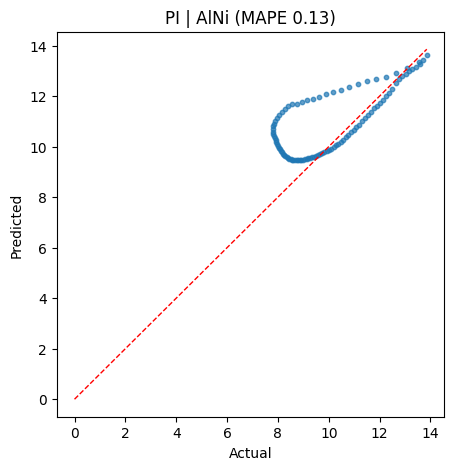

[PI] Left-out: AlNi | Test MAPE: 0.1253
[PI] CuMg | Epoch 10/100 Loss: 73.8894
[PI] CuMg | Epoch 20/100 Loss: 36.0844
[PI] CuMg | Epoch 30/100 Loss: 11.5145
[PI] CuMg | Epoch 40/100 Loss: 4.0130
[PI] CuMg | Epoch 50/100 Loss: 2.8729
[PI] CuMg | Epoch 60/100 Loss: 2.6165
[PI] CuMg | Epoch 70/100 Loss: 2.4018
[PI] CuMg | Epoch 80/100 Loss: 2.3098
[PI] CuMg | Epoch 90/100 Loss: 2.1090
[PI] CuMg | Epoch 100/100 Loss: 2.0696


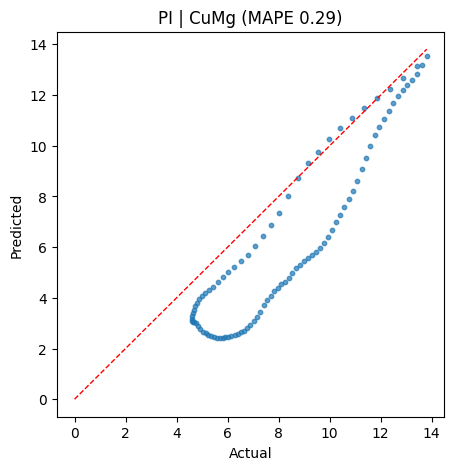

[PI] Left-out: CuMg | Test MAPE: 0.2869
[PI] NiMg | Epoch 10/100 Loss: 66.5626
[PI] NiMg | Epoch 20/100 Loss: 29.3241
[PI] NiMg | Epoch 30/100 Loss: 8.2063
[PI] NiMg | Epoch 40/100 Loss: 3.2890
[PI] NiMg | Epoch 50/100 Loss: 2.8086
[PI] NiMg | Epoch 60/100 Loss: 2.5311
[PI] NiMg | Epoch 70/100 Loss: 2.4258
[PI] NiMg | Epoch 80/100 Loss: 2.2043
[PI] NiMg | Epoch 90/100 Loss: 2.1736
[PI] NiMg | Epoch 100/100 Loss: 2.1133


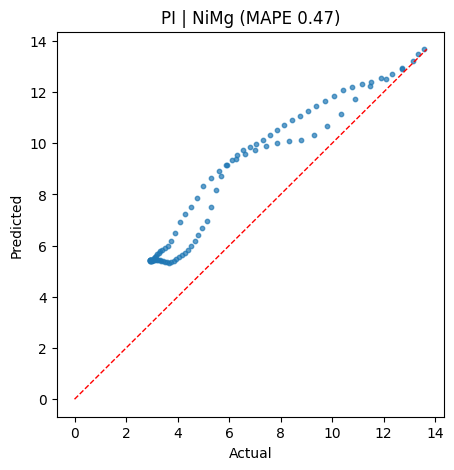

[PI] Left-out: NiMg | Test MAPE: 0.4696
[PI] AlTi | Epoch 10/100 Loss: 73.0198
[PI] AlTi | Epoch 20/100 Loss: 36.9335
[PI] AlTi | Epoch 30/100 Loss: 12.5614
[PI] AlTi | Epoch 40/100 Loss: 4.6016
[PI] AlTi | Epoch 50/100 Loss: 3.3470
[PI] AlTi | Epoch 60/100 Loss: 2.8620


KeyboardInterrupt: 

In [24]:
for name, df in [("PI", df_pi), ("EP", df_ep), ("Comp", df_comp), ("Random", df_rand)]:
    print("test")
    mean_mape, mapes, per_sys = run_loop(df, name, epochs=100, batch_size=512, lr=1e-3, device=device)
    print(f"{name} mean MAPE: {mean_mape:.4f}")
    #plot_pred_vs_actual(per_sys, n=6)
    #plot_error_hist(per_sys)

In [ ]:
pi_mean_mape, pi_mapes, pi_per_sys = run_loop(df_pi, "PI", epochs=50, batch_size=32, lr=1e-3, device=device)

In [ ]:
ep_mean_mape, ep_mapes, ep_per_sys = run_loop(df_ep, "EP", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
comp_mean_mape, comp_mapes, comp_per_sys = run_loop(df_comp, "Comp", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
rand_mean_mape, rand_mapes, rand_per_sys = run_loop(df_rand, "Random", epochs=50, batch_size=32, lr=1e-3)